In [1]:
import numpy as np
import cv2
import os
import keras
import matplotlib.pyplot as plt

from keras.optimizers import SGD
from keras.optimizers import Adam

from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers.core import Dense, Flatten
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

import pydot
import graphviz
from IPython.display import SVG
from keras.utils import model_to_dot

import itertools
%matplotlib inline

Using TensorFlow backend.
c:\users\filip\.conda\envs\soft-ve\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\filip\.conda\envs\soft-ve\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\filip\.conda\envs\soft-ve\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\filip\.conda\envs\soft-ve\lib\site-packag

In [2]:
def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')


In [3]:
def scale_to_range(image):
    return image/255

In [4]:
def matrix_to_vector(image):
    return image.flatten()

In [5]:
def prepare_for_ann(path, output_size):
    inputs = []
    outputs = []
    i=0
    
    for dir in os.listdir(path):
        for img in os.listdir(path+"/"+dir):
            
            label = np.zeros(output_size)
            label[i] = 1
            outputs.append(label)
            
            readedImg = cv2.imread(path+"/"+dir+"/"+img, cv2.IMREAD_GRAYSCALE)
            scale = scale_to_range(readedImg) #zbog brzeg treniranja
            inputs.append(matrix_to_vector(scale))#pripremi za ulaz
            
        i+=1
        
    return inputs, outputs

In [6]:
def prepare_for_predict(path):
    readedImg = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    scale = scale_to_range(readedImg)
    return matrix_to_vector(scale)

In [7]:
#output_size 7
def create_ann(output_size):
    ann = Sequential()
    ann.add(Dense(128, input_dim=40000, activation='sigmoid'))
    ann.add(Dense(output_size, activation='sigmoid'))
    return ann

In [8]:
def train_ann(ann, x_train, y_train, x_validate, y_validate, epochs):
    x_train = np.array(x_train, np.float32) # dati ulaz
    y_train = np.array(y_train, np.float32) # zeljeni izlazi na date ulaze
    
    x_validate = np.array(x_validate, np.float32) 
    y_validate = np.array(y_validate, np.float32)
    
    print("\nTraining started...")
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd, metrics=['acc'])
    ann.summary()
    #SVG(model_to_dot(ann).create(prog='dot', format='svg'))
    history = ann.fit(x_train, y_train, validation_data=(x_validate, y_validate), epochs=epochs, batch_size=10, verbose=1, shuffle=True)

    print("\nTraining completed...")

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    return ann

In [9]:
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

In [10]:
train_path = "prepare_data/train"
valid_path = "prepare_data/valid" 
test_path = "prepare_data/test"

In [11]:
alphabet = ["down","left","no","right","up","up-left","up-right"]
inputs, outputs = prepare_for_ann(train_path, len(alphabet))
inputs_valid, outputs_valid = prepare_for_ann(valid_path, len(alphabet))

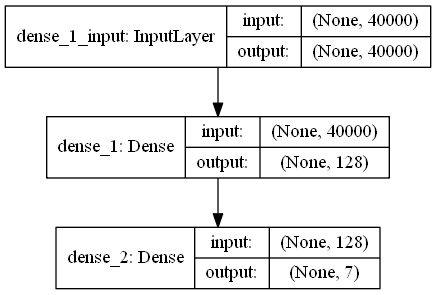

In [12]:
ann = create_ann(len(alphabet))
keras.utils.plot_model(
    ann,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)




Training started...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               5120128   
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903       
Total params: 5,121,031
Trainable params: 5,121,031
Non-trainable params: 0
_________________________________________________________________
Train on 1960 samples, validate on 245 samples
Epoch 1/20
1960/1960 [==============================] - 9s 4ms/step - loss: 0.0560 - acc: 0.8276 - val_loss: 0.0268 - val_acc: 0.9265
Epoch 2/20
1960/1960 [==============================] - 7s 3ms/step - loss: 0.0236 - acc: 0.9638 - val_loss: 0.0184 - val_acc: 0.9755
Epoch 3/20
1960/1960 [==============================] - 7s 4ms/step - loss: 0.0168 - acc: 0.9781 - val_loss: 0.0143 - val_acc: 0.9673
Epoch 4/20
1960/1960 [==============

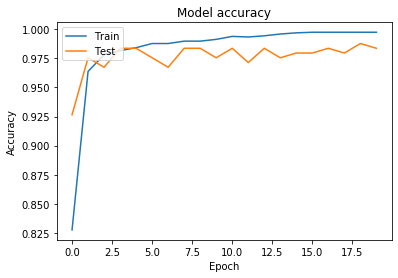

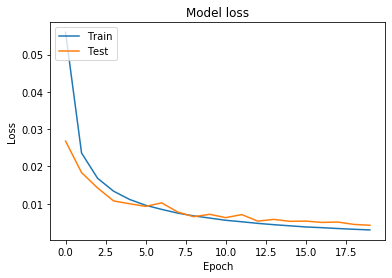

In [13]:
ann = train_ann(ann, inputs, outputs, inputs_valid, outputs_valid, epochs=20) #20

In [14]:
#ann.save('prepare_data/0.9980ac.h5') #OVO MENJAJ

In [15]:
prepered_img1 = prepare_for_predict("prepare_data/test/down/down_316.pgm")
prepered_img2 = prepare_for_predict("prepare_data/test/down/down_327.pgm")
prepered_img3 = prepare_for_predict("prepare_data/test/down/down_350.pgm")
real_inp  = []
real_inp.append(prepered_img1)
real_inp.append(prepered_img2)
real_inp.append(prepered_img3)

In [16]:
result = ann.predict(np.array(real_inp, np.float32))

In [17]:
for r in result:
    win = winner(r)
    print(alphabet[win])

down
down
down
